In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    validation_split=0.2  # 20% of data for validation
)

# Define the data directories
data_dir = '/kaggle/input/fish-dataset/fishDataset'

# Load and augment the data
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use this subset for training
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Use this subset for validation
    shuffle=False
)

Found 20773 images belonging to 14 classes.
Found 5189 images belonging to 14 classes.


In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(14, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

In [6]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping on val_loss with additional patience for val_accuracy
early_stopping_loss = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

callbacks = [early_stopping_loss, model_checkpoint, reduce_lr]

In [9]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725560160.599342    1691 service.cc:145] XLA service 0x793b88002b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725560160.599401    1691 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725560187.623746    1691 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1725560187.671341    1691 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the

159/650 ━━━━━━━━━━━━━━━━━━━━ 5:11 634ms/step - accuracy: 0.6006 - loss: 1.8890

I0000 00:00:1725560287.929706    1691 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_31', 456 bytes spill stores, 456 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads



650/650 ━━━━━━━━━━━━━━━━━━━━ 488s 656ms/step - accuracy: 0.8019 - loss: 0.8799 - val_accuracy: 0.3394 - val_loss: 2.1466 - learning_rate: 1.0000e-04
Epoch 2/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 400s 609ms/step - accuracy: 0.9798 - loss: 0.0792 - val_accuracy: 0.8859 - val_loss: 0.5647 - learning_rate: 1.0000e-04
Epoch 3/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 402s 614ms/step - accuracy: 0.9826 - loss: 0.0668 - val_accuracy: 0.9484 - val_loss: 0.2143 - learning_rate: 1.0000e-04
Epoch 4/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 403s 615ms/step - accuracy: 0.9881 - loss: 0.0371 - val_accuracy: 0.9651 - val_loss: 0.1439 - learning_rate: 1.0000e-04
Epoch 5/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 401s 612ms/step - accuracy: 0.9905 - loss: 0.0370 - val_accuracy: 0.9131 - val_loss: 0.4357 - learning_rate: 1.0000e-04
Epoch 6/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 399s 608ms/step - accuracy: 0.9888 - loss: 0.0438 - val_accuracy: 0.9576 - val_loss: 0.1871 - learning_rate: 1.0000e-04
Epoch 7/30
650/650 ━━━━━━━━━━━━━━━━━━━━ 400s 609ms/

In [10]:
# After training
print("Training history keys:", history.history.keys())


Training history keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


In [11]:
# Load the best model
model.load_weights('best_model.keras')

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 478ms/step - accuracy: 0.9817 - loss: 0.0708
Validation Loss: 0.0436, Validation Accuracy: 0.9873


163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 490ms/step


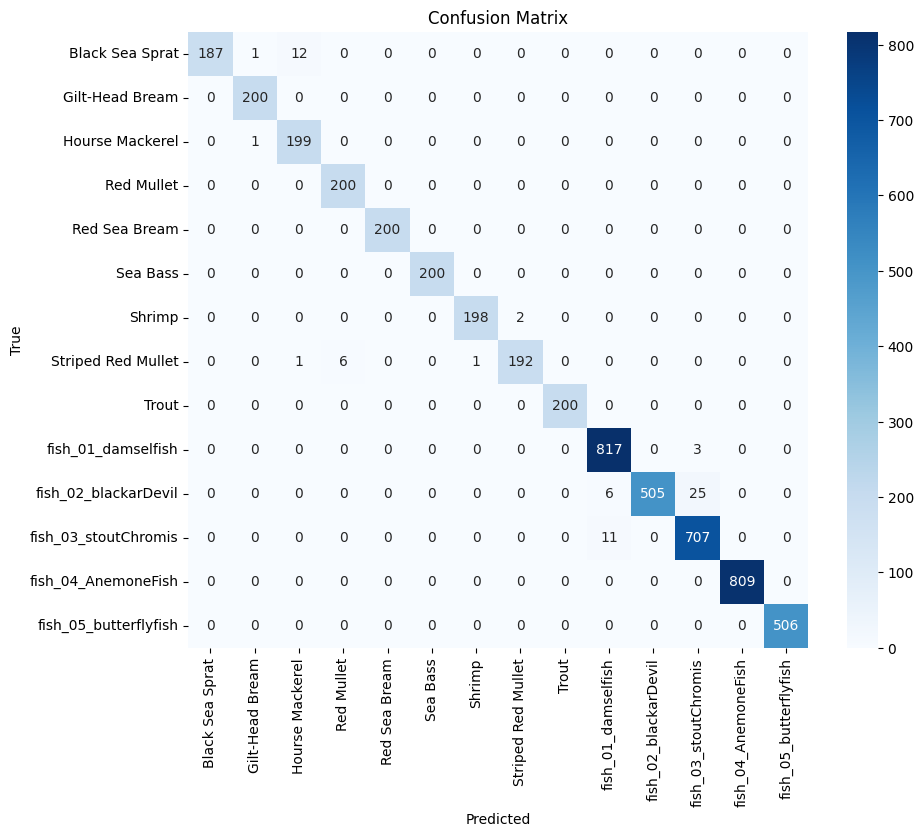

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Extract class labels
class_labels = list(val_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


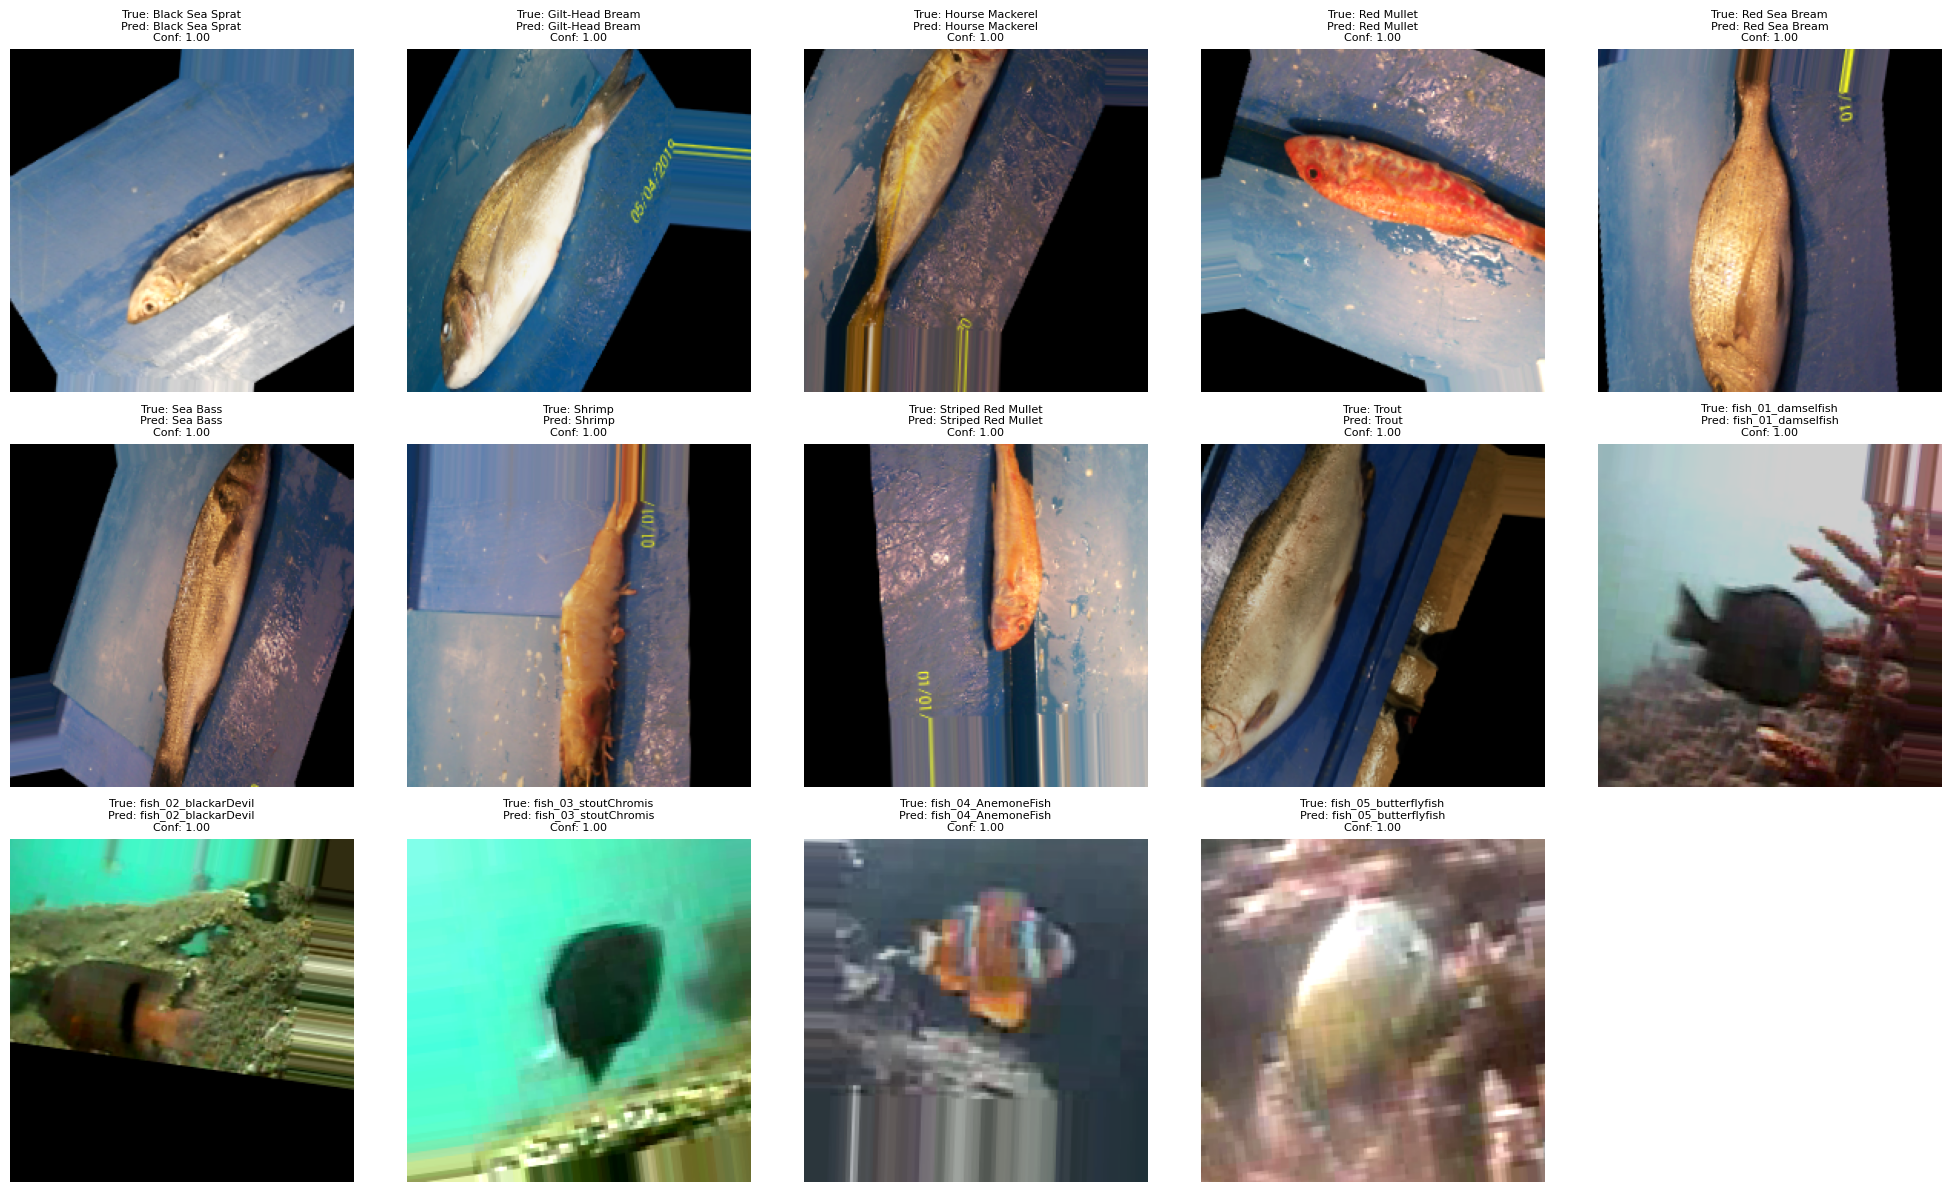

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Create index_to_class dictionary
index_to_class = {v: k for k, v in val_generator.class_indices.items()}

def collect_images_from_each_class(generator, class_indices, num_per_class=1):
    # Dictionary to hold images and labels for each class
    images_per_class = {class_name: [] for class_name in class_indices.keys()}
    labels_per_class = {class_name: [] for class_name in class_indices.keys()}
    
    # Collect images from the generator
    for batch in generator:
        batch_images, batch_labels = batch
        batch_predictions = model.predict(batch_images, verbose=0)
        batch_pred_classes = np.argmax(batch_predictions, axis=1)
        batch_confidences = np.max(batch_predictions, axis=1)
        
        for i in range(len(batch_images)):
            true_label = np.argmax(batch_labels[i])
            true_label_name = index_to_class[true_label]
            predicted_label_name = index_to_class[batch_pred_classes[i]]
            confidence = batch_confidences[i]
            
            # Add the image to the respective class if we need more images
            if len(images_per_class[true_label_name]) < num_per_class:
                images_per_class[true_label_name].append((batch_images[i], true_label_name, predicted_label_name, confidence))
                labels_per_class[true_label_name].append(true_label_name)
        
        # Stop if we have enough images from all classes
        if all(len(images) >= num_per_class for images in images_per_class.values()):
            break
    
    return images_per_class

def plot_images_from_each_class(images_per_class, num_cols=5):
    num_classes = len(images_per_class)
    num_rows = int(np.ceil(num_classes / num_cols))

    plt.figure(figsize=(num_cols * 4, num_rows * 4))

    for i, (class_name, img_data) in enumerate(images_per_class.items()):
        for j, (img, true_label, predicted_label, confidence) in enumerate(img_data):
            plt.subplot(num_rows, num_cols, i * num_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}", fontsize=8)

    plt.tight_layout()
    plt.show()

# Collect images from each class
num_per_class = 1  # Number of images per class to display
images_per_class = collect_images_from_each_class(val_generator, val_generator.class_indices, num_per_class=num_per_class)

# Plot the collected images
plot_images_from_each_class(images_per_class, num_cols=5)


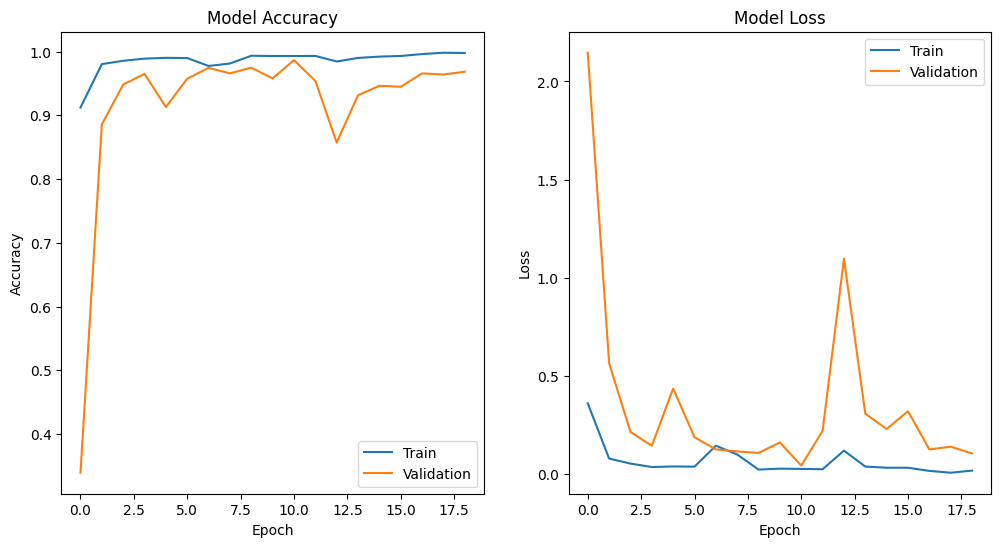

In [14]:
# Assuming `history` is the result of model.fit()
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()


In [18]:
# Get true labels (integers representing classes)
y_true = val_generator.classes

# Get predictions as probabilities
predictions = model.predict(val_generator)

# Convert predictions (probabilities) into class labels
y_pred = np.argmax(predictions, axis=1)

# Now you can use classification metrics like confusion_matrix or classification_report
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
print("Confusion Matrix:")
print(cm)

# Compute and display classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:")
print(report)


163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 479ms/step
Confusion Matrix:
[[188   1  11   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1 199   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 200   0   0   0   0   0   0   0   0   0   0]
 [  0   1   0   0 199   0   0   0   0   0   0   0   0   0]
 [  0   1   1   0   0 197   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0 200   0   0   0   0   0   0   0]
 [  0   0   6   7   0   0   0 187   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 200   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 816   1   3   0   0]
 [  0   0   0   0   0   0   0   0   0   5 511  19   1   0]
 [  0   0   0   0   0   0   0   0   0   7   0 711   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 809   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 506]]
Classification Report:
                       precision    recall  f1-score   support

      Black Sea Sprat   

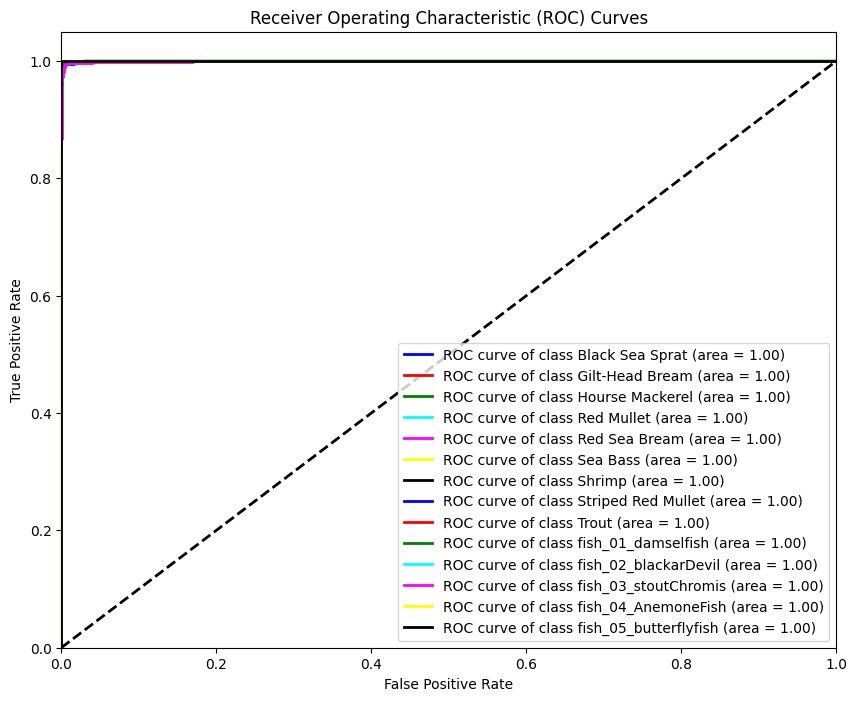

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black'])
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()
